In [10]:
import pickle
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import unicodedata
import string
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
from keras.models import Sequential
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,GlobalMaxPooling1D,SpatialDropout1D,Flatten,GRU, Embedding, Dropout, Activation
from keras.optimizers import Adam
from tensorflow.keras.models import Model

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data= pd.read_json('/content/Sarcasm_Headlines_Dataset.json', lines=True)

In [9]:
data = data.drop('article_link',axis=1)


In [12]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [13]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"i'm" : "i am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [14]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x
    

In [11]:

stop_words = set(nltk.corpus.stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [18]:
def clean_text(text):
  lemmatizer = WordNetLemmatizer()
  soup = BeautifulSoup(text,'html.parser').get_text()
  text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", '', text)
  text = re.sub('[^A-Z a-z 0-9-]+',' ',text)
  text = re.sub('[.!-]+',' ',text)
  text = re.sub(r'http\S+','',text)
  text = re.sub('[\d]','',text)
  text = text.lower()
    
  text = ' '.join([lemmatizer.lemmatize(t) for t in text.split() if t not in stop_words])


  return text

In [19]:
data['headline'] = data['headline'].apply(lambda x: clean_text(x))


In [20]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sue secret black co...,0
1,roseanne revival catch thorny political mood b...,0
2,mom starting fear son web series closest thing...,1
3,boehner want wife listen come alternative debt...,1
4,j k rowling wish snape happy birthday magical way,0


56.0

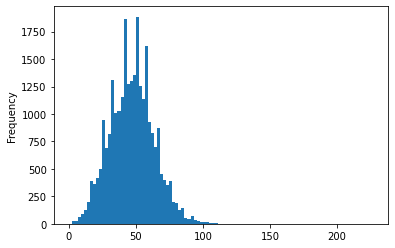

In [25]:
data['len'] = data['headline'].apply(lambda s : len(s))
data['len'].plot.hist(bins=100)
data.len.quantile(0.70)

In [26]:
embed_size = 200 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
batch_size = 512 # how many samples to process at once
n_epochs = 20 # how many times to iterate over all samples
maxlen = 60


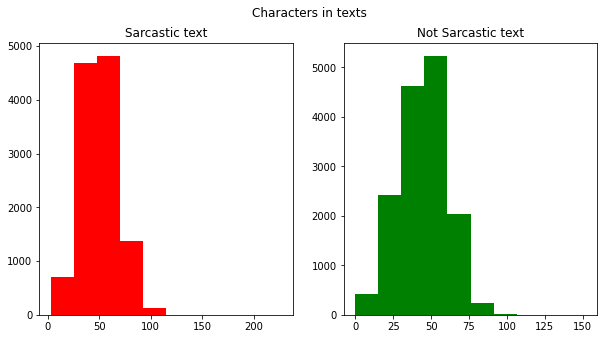

In [27]:
#Number of characters in texts
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

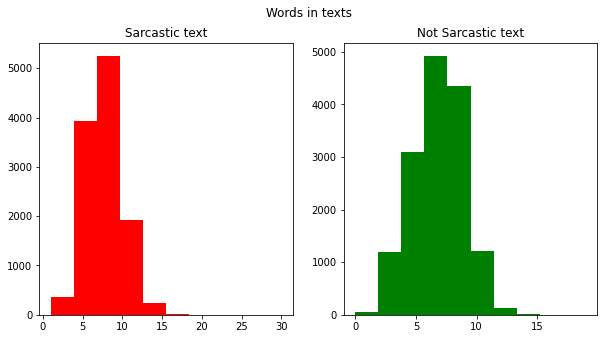

In [28]:
# Number of words in each text

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

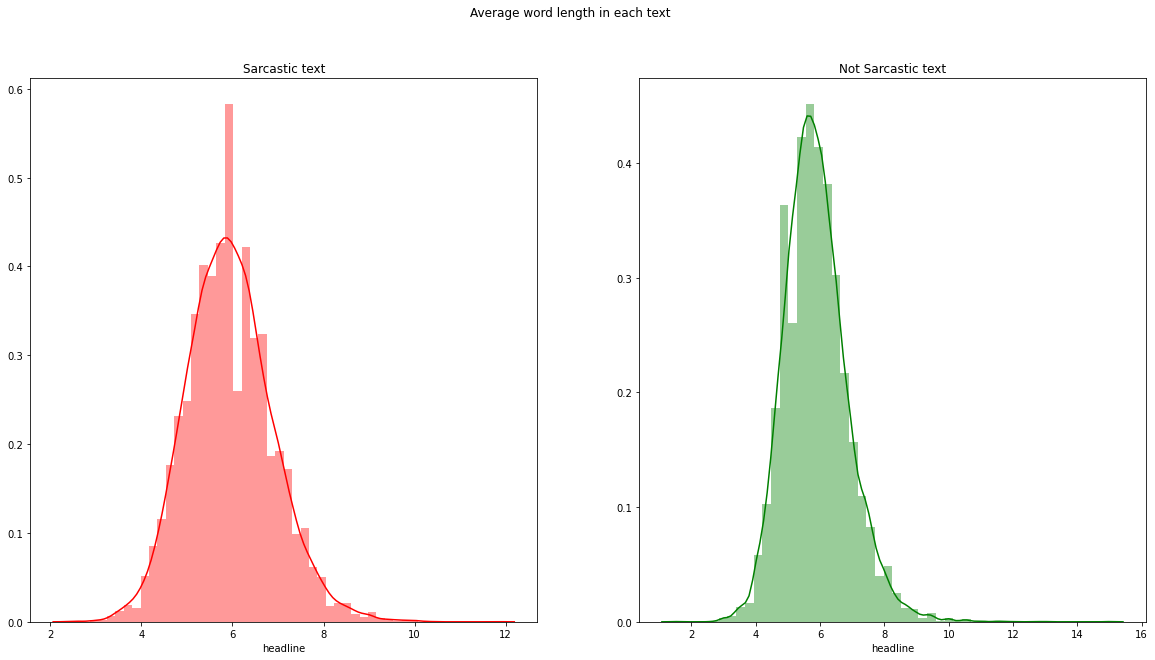

In [29]:
# Average word length in a text

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [30]:
notsarcastic_words = []
for i in list(data.is_sarcastic[data.is_sarcastic==0].index):
    notsarcastic_words.append(data.headline[i])

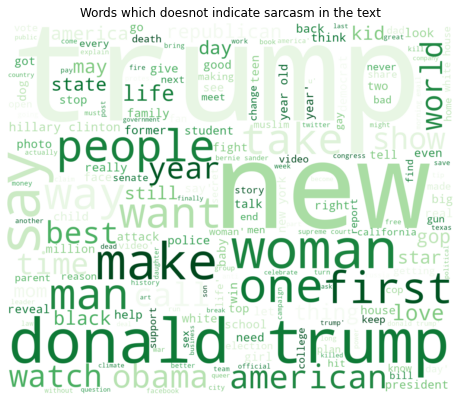

In [34]:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,background_color = 'white',width=1200,height=1000,colormap='Greens').generate(str(notsarcastic_words))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Words which doesnot indicate sarcasm in the text")
plt.show()

In [35]:
y = data['is_sarcastic'].values
X = data['headline']
X = list(X)

In [59]:
from keras.utils import to_categorical
y_binary = to_categorical(y)

In [60]:
y_binary

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [41]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(X)
train_X = tokenizer.texts_to_sequences(X)

# vocabulary
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)

Vocabulary size: 21732


In [42]:
with open('word_index.json', 'w') as f:
    json.dump(word_index, f)
with open('index_word.json', 'w') as f2:
    json.dump(tokenizer.index_word, f2)

In [61]:
print('Shape of data tensor:', train_X.shape)
print('Shape of label tensor:', y_binary.shape)

Shape of data tensor: (26709, 60)
Shape of label tensor: (26709, 2)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y_binary,
                                                    stratify=y_labels, 
                                                    test_size=0.25)

In [65]:
print('X train shape',X_train.shape)
print('y train shape',y_train.shape)
print('X test shape',X_test.shape)
print('y test shape',y_test.shape)


X train shape (20031, 60)
y train shape (20031, 2)
X test shape (6678, 60)
y test shape (6678, 2)


In [67]:
print('Number of entries in each sarcasm class:')
print('training: ', y_train.sum(axis=0))
print('test: ', y_test.sum(axis=0))

Number of entries in each sarcasm class:
training:  [11238.  8793.]
test:  [3747. 2931.]


In [66]:
glove_vectors = dict()
# Creating Dictionary of Word and corresponding Vectors
file = open('/content/drive/My Drive/glove.6B.200d.txt',encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0] # each word 
    vectors = np.asarray(values[1:],dtype='float32')
    glove_vectors[word] = vectors
file.close()

KeyboardInterrupt: ignored

In [49]:
embedding_matrix = np.random.random((len(word_index) + 1, embed_size))


In [50]:
for word,index in word_index.items():
    if index >= max_features:
        continue
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_vector = glove_vectors.get(word.capitalize())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Completed creating embedding matrix')

Completed creating embedding matrix


In [51]:
print("Shape of embedding matrix is {}".format(np.shape(embedding_matrix)))

Shape of embedding matrix is (21733, 200)


In [120]:
from keras.layers import GlobalMaxPool1D, GRU,MaxPool1D,Conv1D

model = Sequential()
model.add(Embedding(len(word_index)+1,embed_size,weights=[embedding_matrix], input_length=maxlen,trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, recurrent_dropout=0.2,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 60, 200)           4346600   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 60, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 100)           120400    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)               

In [121]:
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [124]:
history = model.fit(X_train, y_train, epochs = 5, batch_size=32, validation_data=(X_test, y_test))

Train on 20031 samples, validate on 6678 samples
Epoch 1/5
20031/20031 [==============================] - 51s 3ms/step - loss: 0.4815 - accuracy: 0.7673 - val_loss: 0.4471 - val_accuracy: 0.7890
Epoch 2/5
20031/20031 [==============================] - 51s 3ms/step - loss: 0.4221 - accuracy: 0.8065 - val_loss: 0.4110 - val_accuracy: 0.8110
Epoch 3/5
20031/20031 [==============================] - 51s 3ms/step - loss: 0.3825 - accuracy: 0.8269 - val_loss: 0.4068 - val_accuracy: 0.8130
Epoch 4/5
20031/20031 [==============================] - 51s 3ms/step - loss: 0.3403 - accuracy: 0.8490 - val_loss: 0.4086 - val_accuracy: 0.8191
Epoch 5/5
20031/20031 [==============================] - 50s 3ms/step - loss: 0.3068 - accuracy: 0.8669 - val_loss: 0.4302 - val_accuracy: 0.8113
Train on 20031 samples, validate on 6678 samples
Epoch 1/5
20031/20031 [==============================] - 50s 3ms/step - loss: 0.2815 - accuracy: 0.8803 - val_loss: 0.4071 - val_accuracy: 0.8205
Epoch 2/5
20031/20031 [===

In [138]:
model.save('SarcasmLSTM_model.h5')

In [139]:
from keras.models import load_model
model = load_model('SarcasmLSTM_model.h5')

In [140]:
def predict_sarcasm(sample_review):
    sample_review = [sample_review]
    seq = tokenizer.texts_to_sequences(sample_review)
    padded = pad_sequences(seq, maxlen=maxlen)
    pred = model.predict_classes(padded)
    return pred

import random
sample_text = random.choice(data[["headline",'is_sarcastic']].values.tolist())
prediction = predict_sarcasm(sample_text[0])
print(prediction)
prediction  = int(prediction)
if prediction ==1:
    prediction = 'sarcasm'
else:
    prediction = 'no sarcasm'
print('The sarcasm behind the sentence "{}" is {}: '.format(sample_text[0],prediction))
print('The actual sarcasm behind the sentence "{}" is {}: '.format(sample_text[0],sample_text[1]))



[1]
The sarcasm behind the sentence "lawyer identify dozen bill cosby victim interviewing potential juror" is sarcasm: 
The actual sarcasm behind the sentence "lawyer identify dozen bill cosby victim interviewing potential juror" is 1: 
